# <b>1 <span style='color:lightseagreen'>|</span> Introduction</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.1 | Goal</b></p>
</div>

Welcome to the April edition of the 2022 Tabular Playground Series! This month's challenge is a time series classification problem. You've been provided with thousands of sixty-second sequences of biological sensor data recorded from several hundred participants who could have been in either of two possible activity states. Can you determine what state a participant was in from the sensor data?

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.2 | Competition Metric</b></p>
</div>

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.But what are ROC and AUROC ?

<div class="alert alert-block alert-info"> 📌 The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection. The false-positive rate is also known as probability of false alarm and can be calculated as (1 − specificity). It can also be thought of as a plot of the power as a function of the Type I Error of the decision rule (when the performance is calculated from just a sample of the population, it can be thought of as estimators of these quantities). The ROC curve is thus the sensitivity or recall as a function of fall-out.</div>

![](https://miro.medium.com/max/700/1*PU3_4LheadpGcpl6daO1mA.png)

In [41]:
# Basic Libraries
from IPython.display import clear_output
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pandas_profiling as pp
import seaborn as sns
from IPython.display import display

# Encoders
from pandas.api.types import CategoricalDtype
# from category_encoders import MEstimateEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
# from category_encoders import MEstimateEncoder

# Scikit Learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, learning_curve, train_test_split, GroupKFold

# Algorithms
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

# Optuna - Bayesian Optimization 
# import optuna
# from optuna.samplers import TPESampler

# Plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

# TPS April22 Metric
from sklearn.metrics import roc_auc_score

# Permutation Importance
# import eli5
# from eli5.sklearn import PermutationImportance

# TensorFlow
import typing
from tensorflow import keras as k
if typing.TYPE_CHECKING:
    print("emmm")
    from keras.api._v2 import keras as k

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Multiply

warnings.filterwarnings('ignore')

def load_data():
    # data_dir = Path("../input/tabular-playground-series-apr-2022")
    # df_train = pd.read_csv(data_dir / "train.csv")
    # df_test = pd.read_csv(data_dir / "test.csv")
    # train_labels = pd.read_csv(data_dir / 'train_labels.csv')
    
    df_train = pd.read_pickle('../../dataset/pkl/train.pkl')
    train_labels = pd.read_csv('../../dataset/csv/train_labels.csv')
    df_test = pd.read_pickle('../../dataset/pkl/test.pkl')


    # Merge the splits so we can process them together
    df_train = df_train.merge(train_labels, on='sequence', how='outer')
    df = pd.concat([df_train, df_test])
    return df

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[fi_df.feature_importance > 0]
    fig = px.bar(fi_df, x='feature_names', y='feature_importance', color="feature_importance",
             color_continuous_scale='Blugrn')
    
    # General Styling
    fig.update_layout(height=750, bargap=0.2,
                  margin=dict(b=50,r=30,l=100,t=100),
                  title = "<span style='font-size:36px; font-family:Times New Roman'>Feature Importance Analysis</span>",                  
                  plot_bgcolor='rgb(242,242,242)',
                  paper_bgcolor = 'rgb(242,242,242)',
                  font=dict(family="Times New Roman", size= 14),
                  hoverlabel=dict(font_color="floralwhite"),
                  showlegend=False)
    fig.show()

df_data = load_data()
clear_output()
#pp.ProfileReport(df_data)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.2 | Early Insights</b></p>
</div>

**<span style='color:lightseagreen'>Analysing the previous profiling report</span>** we have been able to observe the following about the dataset given: 

* 2.3M given examples 
* All variables are **<span style='color:lightseagreen'>numerical</span>**.
* No missing values.
* **<span style='color:lightseagreen'>High correlation</span>** between some pairs of sensor features. 
* None of sensor features are **<span style='color:lightseagreen'>uniformly distributed</span>**.

We are going to make a more exhaustive analysis in the following section. 

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.3 | Reducing Memory Usage</b></p>
</div>

As we can observe in the previous report from the dataset, we have the amount of more than **<span style='color:lightseagreen'>2.3 million rows</span>**. Due to that, in order to not having **<span style='color:lightseagreen'>issues with memory</span>** in the kernel, we are going to reduce its memory usage with the following function. Below, we can appreciate that reduction was successful as we manage to make a **<span style='color:lightseagreen'>reduction of 50.7%</span>**.

In [42]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

df_data = reduce_mem_usage(df_data)

Mem. usage decreased to 155.14 Mb (50.7% reduction)


# <b>2 <span style='color:lightseagreen'>|</span> Exploratory Data Analysis</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.1 | Heatmap</b></p>
</div>

Although we had one in the upper report, we are going to plot another in order to **<span style='color:lightseagreen'>analyse and study better</span>** correlations between our features. For anyone interested, my **<span style='color:lightseagreen'>visualizations</span>** are going to be made with **<span style='color:lightseagreen'>Plotly</span>** library. Hope you enjoy them ! **<span style='color:lightseagreen'>Do not hesitate to write me in the comments with any kind of tip to improve them</span>**.

In [43]:
fig = px.imshow(df_data[df_data.state.isnull() == False].corr(), color_continuous_scale='RdBu_r', color_continuous_midpoint=0, origin='lower', aspect='auto')
fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False)
fig.update_yaxes(showgrid = True, gridcolor='gray',gridwidth=0.5, linecolor='gray',linewidth=2, zeroline = False)

# General Styling
fig.update_layout(height=750, bargap=0.2,
                  margin=dict(b=50,r=30,l=100, t=100),
                  title = "<span style='font-size:36px; font-family:Times New Roman'>Heatmap</span>",                  
                  plot_bgcolor='rgb(242,242,242)',
                  paper_bgcolor = 'rgb(242,242,242)',
                  font=dict(family="Times New Roman", size= 14),
                  hoverlabel=dict(font_color="floralwhite"),
                  showlegend=False)
fig.show()

📌 **Interpret:** we can make the following conclusions after analysing the heatmap plotted: 

* State feature is **<span style='color:lightseagreen'>significantly low correlated</span>** with almost every sensor feature. Sensor 2, is the one which is most correlated with target.
* Correlations are **<span style='color:lightseagreen'>all positive</span>**, except few of them. 
* The following **<span style='color:lightseagreen'>sensors features are correlated</span>** between each other: Sensor 0, Sensor 6, Sensor 9, Sensor 3, Sensor 7 and Sensor 11
        
<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.2 | Subject / Sequence Analysis</b></p>
</div>

We have 38186 different sequences (taking into account test sequences as well). Each sequence has 60 time steps. As the train and test subjects are different, we cannot use the subject as a feature. On the contrary: we have to make sure that our classifier generalizes to previously unseen subjects. In the following notebook cell, we check how often each subject occurs in the training data. The most infrequent subject occurs only twice; the most frequent subject is a hundred times more frequent; it occurs 199 times. The picture for the test data is similar.

In [44]:
subject_count = pd.DataFrame(df_data[df_data.state.isnull() == False].subject.value_counts().sort_values() // 60).reset_index()
subject_count.columns = ['subject','count']
subject_count['subject'] = range(1,673)

# chart
fig = make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5], vertical_spacing=0.1, horizontal_spacing=0.1,
                    subplot_titles=('Sequence Count Distribution over Training Subjects','Sequence Count Distribution over Test Subjects'))

fig.add_trace(go.Bar(x=subject_count['subject'], y=subject_count['count'], marker = dict(color=px.colors.sequential.Viridis[5])), row = 1, col = 1)

fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=1)
fig.update_yaxes(showgrid = False, linecolor='gray',linewidth=2, zeroline = False, row=1, col=1)

subject_count = pd.DataFrame(df_data[df_data.state.isnull() == True].subject.value_counts().sort_values() // 60).reset_index()
subject_count.columns = ['subject','count']
subject_count['subject'] = range(319)

fig.add_trace(go.Bar(x=subject_count['subject'], y=subject_count['count'], marker = dict(color=px.colors.sequential.Viridis[5])), row = 1, col = 2)

fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=2)
fig.update_yaxes(showgrid = False, linecolor='gray',linewidth=2, zeroline = False, row=1, col=2)

# General Styling
fig.update_layout(height=400, bargap=0.2,
                  margin=dict(b=50,r=30,l=100),
                  title = "<span style='font-size:36px; font-family:Times New Roman'>Sequence Count Analysis</span>",                  
                  plot_bgcolor='rgb(242,242,242)',
                  paper_bgcolor = 'rgb(242,242,242)',
                  font=dict(family="Times New Roman", size= 14),
                  hoverlabel=dict(font_color="floralwhite"),
                  showlegend=False)

In [45]:
mean_state = df_data[df_data.state.isnull() == False].groupby('subject').agg({'state':'mean'}).reset_index().sort_values(by='state',ascending=False)
fig = px.scatter(mean_state, x='subject',y='state', color="state", color_continuous_scale='Blugrn', size='state')

fig.update_xaxes(showgrid = False, showline = True, gridwidth = 0.05, linecolor = 'gray', zeroline = False, linewidth = 2)
fig.update_yaxes(showline = True, gridwidth = 0.05, linecolor = 'gray', linewidth = 2, zeroline = False)

# General Styling
fig.update_layout(height=500,
              margin=dict(b=50,r=30,l=100,t=100),
              title = "<span style='font-size:36px; font-family:Times New Roman'>Subject Probability State Analysis</span>",                  
              plot_bgcolor='rgb(242,242,242)',
              paper_bgcolor = 'rgb(242,242,242)',
              font=dict(family="Times New Roman", size= 14),
              hoverlabel=dict(font_color="floralwhite"),
              showlegend=False)
fig.show()

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.3 | Sensor Features</b></p>
</div>

### 2.2.3 | Time Steps

Time-step features let us model **<span style='color:lightseagreen'>time dependence</span>**. A series is time dependent if its values can be predicted from the time they occured. In the Hardcover Sales series, we can predict that sales later in the month are generally higher than sales earlier in the month.

In [46]:
sensors = df_data[df_data.state.isnull() == False].columns[df_data[df_data.state.isnull() == False].columns.str.contains('sensor')]

steps_0 = df_data.query('state == 0').pivot_table(
    index=['step'],
    values=sensors,
    aggfunc='mean'
)

steps_1 = df_data.query('state == 1').pivot_table(
    index=['step'],
    values=sensors,
    aggfunc='mean'
)

def plot_steps0(fig, feature):
    fig.add_trace(go.Scatter(x=steps_0.index, y=steps_0[feature], 
                  mode='lines+markers', marker = dict(color = px.colors.qualitative.G10[9]), name='State 0', visible=(feature==default_sensor)))

    fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False)
    fig.update_yaxes(showgrid = False, linecolor='gray', linewidth=2, zeroline = False)
    
def plot_steps1(fig, feature):
    fig.add_trace(go.Scatter(x=steps_1.index, y=steps_1[feature], 
                  mode='lines+markers', marker = dict(color = px.colors.sequential.Viridis[6]), name='State 1', visible=(feature==default_sensor)))
    
    fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False)
    fig.update_yaxes(showgrid = False, linecolor='gray', linewidth=2, zeroline = False)

fig = go.Figure()

sensor_plot_names = []
buttons=[]
default_sensor = "sensor_00"

for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plot_steps0(fig, sensor_name)
    plot_steps1(fig, sensor_name)
    
    sensor_plot_names.extend([sensor_name]*2)
    
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    buttons.append(dict(method='update',
                        label=sensor_name,
                        args = [{'visible': [sensor_name==r for r in sensor_plot_names]}]))

# General Layout. Add dropdown menus to the figure
fig.update_layout(height=500,
              margin=dict(b=50,r=30,l=100,t=100),
              title = "<span style='font-size:36px; font-family:Times New Roman'>Time Steps Analysis</span>",                  
              plot_bgcolor='rgb(242,242,242)',
              paper_bgcolor = 'rgb(242,242,242)',
              font=dict(family="Times New Roman", size= 14),
              hoverlabel=dict(font_color="floralwhite"),
              showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": 0, "showactive": True, "x": 0.5, "y": 1.22}])

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=1.21,
    xanchor="right",
    x=1,
    #bgcolor="white",
    #bordercolor="Black",
    font=dict(
        family="Times New Roman",
        size=12
    #    color="black"
    ),
))

fig.show()

📌 **Interpret:** in this previous chart we have plotted every **<span style='color:lightseagreen'>sensor mean value per step, depending whether the state</span>** is 0 or 1. We can appreciate that for most sensors the graphs have peaks and troughs. However, let's take a look at the case of **<span style='color:lightseagreen'>sensor 2</span>**. Surprisingly, both scatter lines do not cut off at any point. Indeed, both lines seem to be almost constant functions with **<span style='color:lightseagreen'>very distinct values</span>**. 
### 2.3.2 | Distributions

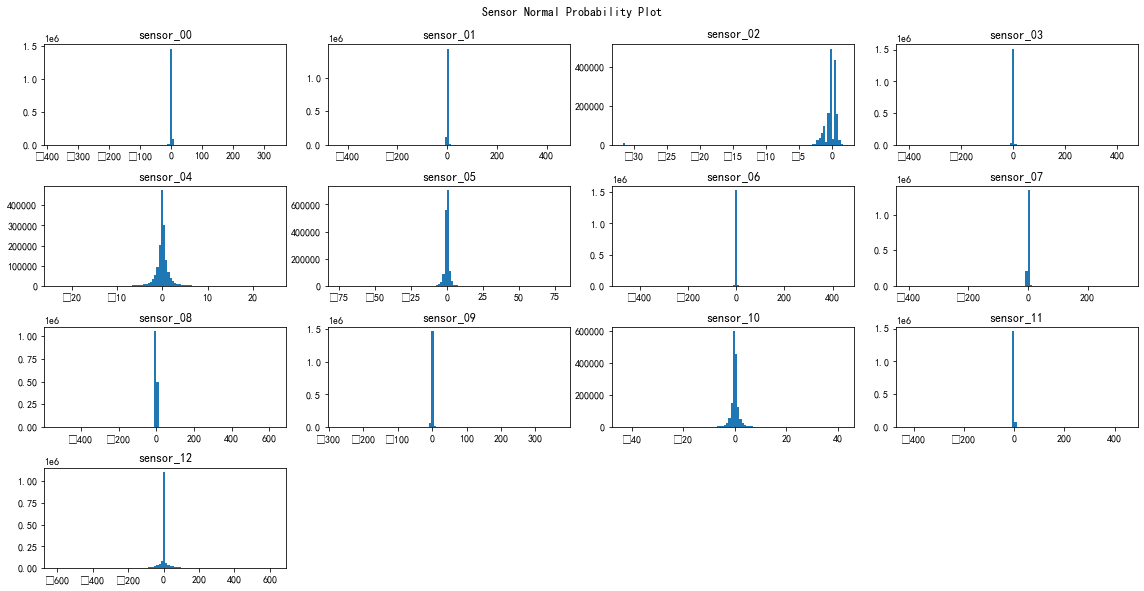

In [47]:
figure = plt.figure(figsize=(16, 8))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    plt.hist(df_data[df_data.state.isnull() == False][f"{sensor_name}"], bins=100)
    plt.title(f"{sensor_name}")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Sensor Normal Probability Plot', y=1.02)
plt.show()

📌 **Interpret:** we can make the following conclusions after analysing the histograms plotted: 

* The histograms show that every sensor has outliers.
* Most sensor features values have big amounts of zeros.
* Sensor features are not normally distributed.

### 2.3.2 | Skewness and Kurtosis

[Skewness and Kurtosis Tutorial](https://www.universoformulas.com/estadistica/descriptiva/asimetria-curtosis/)

Let's now check **<span style='color:lightseagreen'>skewness</span>**. Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive, zero, negative, or undefined.

For a unimodal distribution, negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right. In cases where one tail is long but the other tail is fat, skewness does not obey a simple rule. For example, a zero value means that the tails on both sides of the mean balance out overall; this is the case for a symmetric distribution, but can also be true for an asymmetric distribution where one tail is long and thin, and the other is short but fat. A skewness greater than 1 is generally judged to be skewed, so check mainly those greater than 1.

In [48]:
from scipy.stats import skew, kurtosis
sensors = quantitative = [f for f in df_data.columns if df_data.dtypes[f] == 'float32']
sensors.remove('state')
skew_features = pd.DataFrame(df_data[sensors].apply(lambda x : skew(x))).reset_index()
skew_features.columns = ['sensor','skewness']
line = pd.DataFrame(dict(
    x = ['sensor_00','sensor_12'],
    y = [1, 1]
))

fig = px.bar(skew_features, x='sensor',y='skewness', color = 'skewness', color_continuous_scale = 'Blugrn', range_y=[-14,10])

fig.update_xaxes(showgrid = False, showline = True, gridwidth = 0.05, linecolor = 'gray', linewidth = 2)
fig.update_yaxes(showline = True, gridwidth = 0.05, linecolor = 'gray', linewidth = 2, zerolinecolor = 'gray', zerolinewidth = 0.5)

# General Styling
fig.update_layout(height=500,
              margin=dict(b=50,r=30,l=100,t=100),
              title = "<span style='font-size:36px; font-family:Times New Roman'>Sensors' Skewness</span>",                  
              plot_bgcolor='rgb(242,242,242)',
              paper_bgcolor = 'rgb(242,242,242)',
              font=dict(family="Times New Roman", size= 14),
              hoverlabel=dict(font_color="floralwhite"),
              showlegend=False)
fig.show()

Let's now move into **<span style='color:lightseagreen'>kurtosis</span>**. In probability theory and statistics, kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable. Like skewness, kurtosis describes the shape of a probability distribution and there are different ways of quantifying it for a theoretical distribution and corresponding ways of estimating it from a sample from a population. Different measures of kurtosis may have different interpretations.

The standard measure of a distribution's kurtosis, originating with Karl Pearson, is a scaled version of the fourth moment of the distribution. This number is related to the tails of the distribution, not its peak; hence, the sometimes-seen characterization of kurtosis as "peakedness" is incorrect. For this measure, higher kurtosis corresponds to greater extremity of deviations (or outliers), and not the configuration of data near the mean.

In [49]:
skew_features = pd.DataFrame(df_data[sensors].apply(lambda x : kurtosis(x))).reset_index()
skew_features.columns = ['sensor','kurtosis']
fig = px.bar(skew_features, x='sensor',y='kurtosis', color = 'kurtosis', color_continuous_scale = 'Blugrn')

fig.update_xaxes(showgrid = False, showline = True, gridwidth = 0.05, linecolor = 'gray', linewidth = 2)
fig.update_yaxes(showline = True, gridwidth = 0.05, linecolor = 'gray', linewidth = 2, zerolinecolor = 'gray', zerolinewidth = 0.5)

# General Styling
fig.update_layout(height=500,
              margin=dict(b=50,r=30,l=100,t=100),
              title = "<span style='font-size:36px; font-family:Times New Roman'>Sensors' Kurtosis</span>",                  
              plot_bgcolor='rgb(242,242,242)',
              paper_bgcolor = 'rgb(242,242,242)',
              font=dict(family="Times New Roman", size= 14),
              hoverlabel=dict(font_color="floralwhite"),
              showlegend=False)
fig.show()

Now let's plot the "inner" part of the histogram after removing 2 % outliers on either side. We see that the sensors differ in their characteristics:

* Most measurements of sensor_02 return multiples of 0.33 (but the values in between occur with a low probability).
* Sensor_08 has discrete values (multiples of 0.1).
* Some sensors look like normal distributions, others (in particular sensor_12) have a long tail.

The distributions look symmetric with the center at 0. This next cell of the EDA has been taken from [Ambros EDA Section](https://www.kaggle.com/code/ambrosm/tpsapr22-eda-which-makes-sense/notebook).

In [50]:
figure = plt.figure(figsize=(16, 8))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    plt.hist(df_data[df_data.state.isnull() == False][sensor_name], bins=100,
             range=(df_data[df_data.state.isnull() == False][sensor_name].quantile(0.02),
                    df_data[df_data.state.isnull() == False][sensor_name].quantile(0.98)))
    plt.title(f"{sensor_name} histogram")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Sensor Histograms After Outlier Removal', y=1.02)
plt.show()

### 2.3.3 Normal Probability Plot
The **<span style='color:lightseagreen'>normal probability plot</span>** is a graphical technique for assessing whether or not a data set is approximately normally distributed. The data are plotted against a theoretical normal distribution in such a way that the points **<span style='color:lightseagreen'>should form an approximate straight line</span>**.

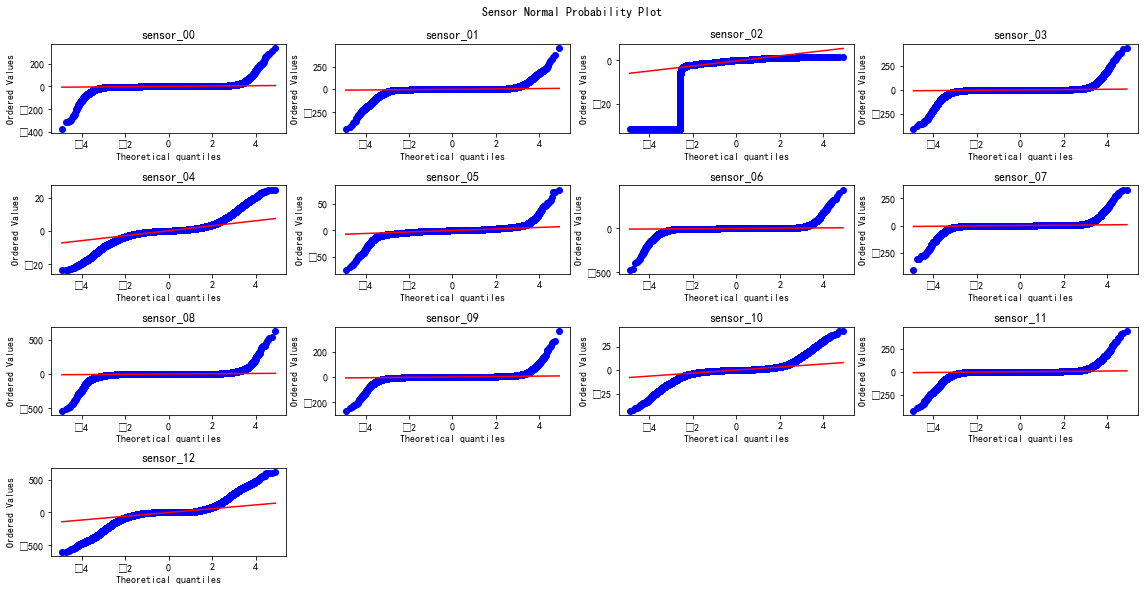

In [51]:
from scipy import stats
figure = plt.figure(figsize=(16, 8))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    stats.probplot(df_data[df_data.state.isnull() == False][f"{sensor_name}"], plot=plt)
    plt.title(f"{sensor_name}")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Sensor Normal Probability Plot', y=1.02)
plt.show()

from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
figure = plt.figure(figsize=(16, 8))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    plot_acf(df_data[sensor_name],lags=10)
    plt.title(f"{sensor_name}")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Autocorrelation Analysis', y=1.02)
plt.show()
plot_pacf(df_data['sensor_03'],lags=2,title="Sensor 2")

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.4 | Outliers</b></p>
</div>

### 2.4.1 | Outliers Definition
Outlier is an observation that is numerically distant from the rest of the data or in a simple word it is the value which is out of the range.let’s take an example to check what happens to a data set with and data set without outliers.

### 2.4.2 | Outliers Detection

Outlier can be of two types: Univariate and Multivariate. These outliers can be found when we look at distribution of a single variable. Multi-variate outliers are outliers in an n-dimensional space. We'll start by detecting whether there are outliers in our dataset or not. 

#### 2.4.2.1 | Grubbs Test

$$
\begin{array}{l}{\text { Grubbs' test is defined for the hypothesis: }} \\ {\begin{array}{ll}{\text { Ho: }}  {\text { There are no outliers in the data set }} \\ {\mathrm{H}_{\mathrm{1}} :}  {\text { There is exactly one outlier in the data set }}\end{array}}\end{array}
$$
$$
\begin{array}{l}{\text {The Grubbs' test statistic is defined as: }} \\ {\qquad G_{calculated}=\frac{\max \left|X_{i}-\overline{X}\right|}{SD}} \\ {\text { with } \overline{X} \text { and } SD \text { denoting the sample mean and standard deviation, respectively. }} \end{array}
$$
$$
G_{critical}=\frac{(N-1)}{\sqrt{N}} \sqrt{\frac{\left(t_{\alpha /(2 N), N-2}\right)^{2}}{N-2+\left(t_{\alpha /(2 N), N-2}\right)^{2}}}
$$

\begin{array}{l}{\text { If the calculated value is greater than critical, you can reject the null hypothesis and conclude that one of the values is an outlier }}\end{array}

In [52]:
import scipy.stats as stats
def grubbs_test(x):
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x-mean_x))
    g_calculated = numerator/sd_x
    print("Grubbs Calculated Value:",g_calculated)
    t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    print("Grubbs Critical Value:",g_critical)
    if g_critical > g_calculated:
        print("From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers\n")
    else:
        print("From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers\n")

#### 2.4.2.2 | Z-score method

Using Z score method,we can find out how many standard deviations value away from the mean. 

![minipic](https://i.pinimg.com/originals/cd/14/73/cd1473c4c82980c6596ea9f535a7f41c.jpg)

 Figure in the left shows area under normal curve and how much area that standard deviation covers.
* 68% of the data points lie between + or - 1 standard deviation.
* 95% of the data points lie between + or - 2 standard deviation
* 99.7% of the data points lie between + or - 3 standard deviation

$\begin{array}{l} {R.Z.score=\frac{0.6745*( X_{i} - Median)}{MAD}}  \end{array}$

If the z score of a data point is more than 3 (because it cover 99.7% of area), it indicates that the data value is quite different from the other values. It is taken as outliers.

In [53]:
out=[]
def Zscore_outlier(df):
    m = np.mean(df)
    sd = np.std(df)
    row = 0
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            out.append(row)
        row += 1
    return out

### 2.4.3 | Sensor Outliers Detection

In [54]:
def plot_outliers(feature):
    grubbs_test(df_data[df_data.state.isnull() == False][feature])
    outliers_index = Zscore_outlier(df_data[df_data.state.isnull() == False][feature])
    print('Outlier %: ', len(outliers_index)/df_data[df_data.state.isnull() == False].shape[0])
    print('\n')

    df_outlier = df_data[df_data.state.isnull() == False]
    df_outlier['outlier'] = 0
    df_outlier.loc[outliers_index,'outlier'] = 1

    fig = px.scatter(df_outlier.loc[outliers_index,:], x=outliers_index, y=feature, color = feature, color_continuous_scale='Blugrn', color_continuous_midpoint=0)
    fig.update_xaxes(showgrid = False, showline = True, gridwidth = 0.05, linecolor = 'gray', zeroline = False, linewidth = 2)
    fig.update_yaxes(showline = True, gridwidth = 0.05, linecolor = 'gray', linewidth = 2, zeroline = False)

    #General Styling
    fig.update_layout(height=400, bargap=0.2,
                      margin=dict(b=50,r=30,l=100, t=80),
                      title = "<span style='font-size:36px; font-family:Times New Roman'>Sensor Features Outliers Analysis</span>",                  
                      plot_bgcolor='rgb(242,242,242)',
                      paper_bgcolor = 'rgb(242,242,242)',
                      font=dict(family="Times New Roman", size= 14),
                      hoverlabel=dict(font_color="floralwhite"),
                      showlegend=False)
    fig.show()

sensors = quantitative = [f for f in df_data.columns if df_data.dtypes[f] == 'float32']
sensors.remove('state')
i = 0
for sensor in sensors:
    print('Sensor ', i)
    print('\n')
    i+=1
    plot_outliers(sensor)

Sensor  0


Grubbs Calculated Value: 141.07125197487724
Grubbs Critical Value: 5.529603282250241
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers

Outlier %:  0.005020281371944958




Sensor  1


Grubbs Calculated Value: 102.08269937452043
Grubbs Critical Value: 5.529603282250241
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers

Outlier %:  0.011068751283631136




Sensor  2


Grubbs Calculated Value: 13.682183199382893
Grubbs Critical Value: 5.529603282250241
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers

Outlier %:  0.01595746046416102




Sensor  3


Grubbs Calculated Value: 110.98939856349493
Grubbs Critical Value: 5.529603282250241
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers

Outlier %:  0.020528470938591087




Sensor  4


Grubbs Calculated Value: 14.773967793009314
Grubbs Critical Value: 5.529603282250241
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers



# <b>3 <span style='color:lightseagreen'>|</span> Feature Engineering</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>3.1 | Mutual Information</b></p>
</div>

Mutual information describes **<span style='color:lightseagreen'>relationships</span>** in terms of **<span style='color:lightseagreen'>uncertainty</span>**. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target? Scikit-learn has two mutual information **<span style='color:lightseagreen'>metrics</span>** in its feature_selection module: one for **<span style='color:lightseagreen'>real-valued targets</span>** (mutual_info_regression) and one for **<span style='color:lightseagreen'>categorical targets</span>** (mutual_info_classif). The next cell computes the MI scores for our features and wraps them up in a nice dataframe. Hereafter, we are going to drop uninformative features as they are useless.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object","category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    #discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def uninformative_cols(df, mi_scores):
    return df.loc[:, mi_scores == 0.0].columns
    
y = df_data[df_data.state.isnull() == False]['state']
x = df_data[df_data.state.isnull() == False].drop(['state','sequence','subject'],axis=1)

mi_scores = make_mi_scores(x, y)
#col = uninformative_cols(x, mi_scores)
#x = x.drop(col,axis=1)
print('Uninformative features:\n{}'.format(mi_scores[mi_scores == 0.0]))
mi_scores = pd.DataFrame(mi_scores).reset_index().rename(columns={'index':'Feature'})

Hereafter, we are gooin to plot results obtained previously in order to regard which features are the **<span style='color:lightseagreen'>most informative</span>**, and which ones requires some more analysis. You can see that we have a number of features that are highly informative and also some that don't seem to be informative at all (at least by themselves). Top scoring features will usually pay-off the **<span style='color:lightseagreen'>most during feature development</span>**, so it could be a good idea to focus your efforts on those. On the other hand, training on uninformative features can lead to overfitting.

In [ ]:
fig = px.bar(mi_scores, x='MI Scores', y='Feature', color="MI Scores", color_continuous_scale='darkmint')

fig.update_xaxes(showgrid = False, showline = True, gridwidth = 0.05, linecolor = 'gray', zeroline = False, linewidth = 2)
fig.update_yaxes(showline = True, gridwidth = 0.05, linecolor = 'gray', linewidth = 2, zeroline = False)

fig.update_layout(height = 750, title_text="Mutual Information Scores", plot_bgcolor='rgb(242, 242, 242)', paper_bgcolor = 'rgb(242, 242, 242)',
                  title_font=dict(size=29, family="Lato, sans-serif"), xaxis={'categoryorder':'category ascending'}, margin=dict(t=80))

📌 **Interpret:** we can appreciate that every sensor feature has scored a very low value of Mutual Information. This means that they do not seem so informative, **<span style='color:lightseagreen'>at least by themselves</span>**. Therefore, in next sections we'll focus on creating features related to these sensors, in order to get features with better MI Scores. 

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>3.2 | Statistics Features</b></p>
</div>

In this section we'll be creating some new features related to Sensor ones. We are going to start with some statistic features. The procedure will be grouping by each different sequence and then, adding features for: maximum, minimum, mean, median, std and kurtosis. Hereafter, we'll make an exhaustive analysis, in order to study which statistic features works better.

In [ ]:
import scipy.stats
sensors = [col for col in df_data.columns if 'sensor_' in col]
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"    
    df_data[f'{sensor_name}''_max'] = df_data.groupby('sequence')[f'{sensor_name}'].transform('max') 
    df_data[f'{sensor_name}''_min'] = df_data.groupby('sequence')[f'{sensor_name}'].transform('min') 
    df_data[f'{sensor_name}''_mean'] = df_data.groupby('sequence')[f'{sensor_name}'].transform('mean')  
    df_data[f'{sensor_name}''_std'] = df_data.groupby('sequence')[f'{sensor_name}'].transform('std')  
    df_data[f'{sensor_name}''_median'] = df_data.groupby('sequence')[f'{sensor_name}'].transform('median')
    df_data[f'{sensor_name}''_flip'] = df_data[f'{sensor_name}'] * -1
# Kurtosis
sequence = df_data.sequence.unique()
length = range(60)
for sensor in range(13):
    kurtosis = []
    sensor_name = f"sensor_{sensor:02d}"
    for i in sequence: 
        kurt = scipy.stats.kurtosis(df_data[df_data.sequence == i][sensor_name])
        for j in length:
            kurtosis.append(kurt)
    df_data[sensor_name + '_kurtosis'] = kurtosis

### 3.2.1 | Feature Selection

In this section we'll analyse the usefulness of the features that we've just created. We'll plot how the target depends on every feature, that is, a diagram of $P(y=1|x)$. To get a meaningful plot, we apply two transformations:

* The x axis is not the value of the feature, but its index (when sorted by feature value).
* The y axis is not the target value (which can be only 0 or 1), but a rolling mean over 1000 targets.

Features with an horizontal line as diagram (the probability of the positive target is 0.5 independently of the feature value), are going to be considered bad ones, not useful. On the other hand, good features would have a curve with high $y_{max} - y_{min}$.

#### 3.2.1.1 | Max Features

We can observe that almost each of them presents a 'normal' (not high enough to be directly selected) value of difference between maximum and miminum value on their respective diagram. Thus, they could be useful for us. We do not discard any of those yet.

In [ ]:
state = []
length = range(int(df_data[df_data.state.isnull() == False].shape[0] / 60))
df_train = df_data[df_data.state.isnull() == False]
for j in length:
    state.append(df_train.at[60*j,'state'])

max_df = pd.DataFrame({'state':state})
max_cols = [col for col in df_data.columns if '_max' in col]
for col in max_cols:
    values=[]
    for i in length:
         values.append(df_train.at[60*i,col])
    max_df[col] = values
            
plt.subplots(1, 4, sharey=True, sharex=True, figsize=(20, 25))
counter = 1
for col in max_df.drop('state',axis=1).columns:
    temp = pd.DataFrame({col: max_df[col].values,
                        'state': max_df['state']})
    
    temp = temp.sort_values(col)
    temp.reset_index(inplace=True)
    plt.subplot(15, 4, counter)
    plt.scatter(temp.index, temp.state.rolling(1000).mean(), s=2)
    plt.xlabel(col)
    plt.xticks([])
    counter = counter +1
plt.show()

#### 3.2.1.2 | Min Features

In this case, we can observe that there are some features (like sensor_06_min) that present almost a horizontal line diagram. Those features, as commented previously are not going to be quite useful.

In [ ]:
max_df = pd.DataFrame({'state':state})
max_cols = [col for col in df_data.columns if '_min' in col]
for col in max_cols:
    values=[]
    for i in length:
         values.append(df_train.at[60*i,col])
    max_df[col] = values
            
plt.subplots(1, 4, sharey=True, sharex=True, figsize=(20, 25))
counter = 1
for col in max_df.drop('state',axis=1).columns:
    temp = pd.DataFrame({col: max_df[col].values,
                        'state': max_df['state']})
    
    temp = temp.sort_values(col)
    temp.reset_index(inplace=True)
    plt.subplot(15, 4, counter)
    plt.scatter(temp.index, temp.state.rolling(1000).mean(), s=2)
    plt.xlabel(col)
    plt.xticks([])
    counter = counter +1
plt.show()

#### 3.2.1.3 | Mean Features

Now, regarding mean features charts we can observe that a big amount of them are convex curves. But taking a view carefully, we can appreciate that some of them have a low value of difference between the maxim and minimum value. Some of them are: sensor_00, sensor_03, sensor_05, sensor_09, sensor_10.

In [ ]:
max_df = pd.DataFrame({'state':state})
max_cols = [col for col in df_data.columns if '_mean' in col]
for col in max_cols:
    values=[]
    for i in length:
         values.append(df_train.at[60*i,col])
    max_df[col] = values
            
plt.subplots(1, 4, sharey=True, sharex=True, figsize=(20, 25))
counter = 1
for col in max_df.drop('state',axis=1).columns:
    temp = pd.DataFrame({col: max_df[col].values,
                        'state': max_df['state']})
    
    temp = temp.sort_values(col)
    temp.reset_index(inplace=True)
    plt.subplot(15, 4, counter)
    plt.scatter(temp.index, temp.state.rolling(1000).mean(), s=2)
    plt.xlabel(col)
    plt.xticks([])
    counter = counter +1
plt.show()

#### 3.2.1.4 | Median Features

Median features are not going to be of very usefulness. They're the ones with lowest value on difference between maximum and minimum values.

In [ ]:
max_df = pd.DataFrame({'state':state})
max_cols = [col for col in df_data.columns if '_median' in col]
for col in max_cols:
    values=[]
    for i in length:
         values.append(df_train.at[60*i,col])
    max_df[col] = values
            
plt.subplots(1, 4, sharey=True, sharex=True, figsize=(20, 25))
counter = 1
for col in max_df.drop('state',axis=1).columns:
    temp = pd.DataFrame({col: max_df[col].values,
                        'state': max_df['state']})
    
    temp = temp.sort_values(col)
    temp.reset_index(inplace=True)
    plt.subplot(15, 4, counter)
    plt.scatter(temp.index, temp.state.rolling(1000).mean(), s=2)
    plt.xlabel(col)
    plt.xticks([])
    counter = counter +1
plt.show()

#### 3.2.1.5 | Std Features

In this case, we can observe one potential feature. That's the case of **<span style='color:lightseagreen'>sensor_02_std</span>**. Looking at the y-axes, we can appreciate that difference value is quite high.

In [ ]:
max_df = pd.DataFrame({'state':state})
max_cols = [col for col in df_data.columns if '_std' in col]
for col in max_cols:
    values=[]
    for i in length:
         values.append(df_train.at[60*i,col])
    max_df[col] = values
            
plt.subplots(1, 4, sharey=True, sharex=True, figsize=(20, 25))
counter = 1
for col in max_df.drop('state',axis=1).columns:
    temp = pd.DataFrame({col: max_df[col].values,
                        'state': max_df['state']})
    
    temp = temp.sort_values(col)
    temp.reset_index(inplace=True)
    plt.subplot(15, 4, counter)
    plt.scatter(temp.index, temp.state.rolling(1000).mean(), s=2)
    plt.xlabel(col)
    plt.xticks([])
    counter = counter +1
plt.show()

#### 3.2.1.6 | Kurtosis Features

By far, kurtosis features are the best ones. We can observe plenty potential feature. That's the case of **<span style='color:lightseagreen'>sensor_04_kurtosis</span>**, for example. Looking at the y-axes, we can appreciate that difference value is incredibly high.

In [ ]:
max_df = pd.DataFrame({'state':state})
max_cols = [col for col in df_data.columns if '_kurtosis' in col]
for col in max_cols:
    values=[]
    for i in length:
         values.append(df_train.at[60*i,col])
    max_df[col] = values
            
plt.subplots(1, 4, sharey=True, sharex=True, figsize=(20, 25))
counter = 1
for col in max_df.drop('state',axis=1).columns:
    temp = pd.DataFrame({col: max_df[col].values,
                        'state': max_df['state']})
    
    temp = temp.sort_values(col)
    temp.reset_index(inplace=True)
    plt.subplot(15, 4, counter)
    plt.scatter(temp.index, temp.state.rolling(1000).mean(), s=2)
    plt.xlabel(col)
    plt.xticks([])
    counter = counter +1
plt.show()

#### 3.2.1.7 | Flip Features

We can observe that flip features are completely useless for us. They obtain by far the lowest difference value between $y_{max} - y_{min}$.

In [ ]:
max_df = pd.DataFrame({'state':state})
max_cols = [col for col in df_data.columns if '_flip' in col]
for col in max_cols:
    values=[]
    for i in length:
         values.append(df_train.at[60*i,col])
    max_df[col] = values
            
plt.subplots(1, 4, sharey=True, sharex=True, figsize=(20, 25))
counter = 1
for col in max_df.drop('state',axis=1).columns:
    temp = pd.DataFrame({col: max_df[col].values,
                        'state': max_df['state']})
    
    temp = temp.sort_values(col)
    temp.reset_index(inplace=True)
    plt.subplot(15, 4, counter)
    plt.scatter(temp.index, temp.state.rolling(1000).mean(), s=2)
    plt.xlabel(col)
    plt.xticks([])
    counter = counter +1
plt.show()

📌 **Interpret:** we can make the following conclusions after analysing the previous chart plotted: 

* **<span style='color:lightseagreen'>Kurtosis Features</span>** seems to be the ones working better, as it has obtained the **<span style='color:lightseagreen'>highest difference values</span>** between maximum and minimum values.
* **<span style='color:lightseagreen'>Standard desviation</span>** feature for **<span style='color:lightseagreen'>sensor 2</span>** is one the best ones. 
* **<span style='color:lightseagreen'>Mean and Median</span>** seem to be useless features. 

Taking everything mentioned above into account, we are going to drop the following features:

In [ ]:
max_col = [col for col in df_data.columns if '_max' in col]
min_col = [col for col in df_data.columns if '_min' in col]
mean_col = [col for col in df_data.columns if '_mean' in col]
mean_col.remove('sensor_04_mean')
median_col = [col for col in df_data.columns if '_median' in col]
std_col = [col for col in df_data.columns if '_std' in col]
std_col.remove('sensor_02_std')
kurtosis_col = [col for col in df_data.columns if '_kurtosis' in col]
kurtosis_col.remove('sensor_10_kurtosis')
kurtosis_col.remove('sensor_04_kurtosis')
flip_col = [col for col in df_data.columns if '_flip' in col]

# Drop useless features
df_data = df_data.drop(max_col, axis=1)
df_data = df_data.drop(min_col, axis=1)
df_data = df_data.drop(mean_col, axis=1)
df_data = df_data.drop(std_col, axis=1)
df_data = df_data.drop(median_col, axis=1)
df_data = df_data.drop(kurtosis_col, axis=1)
df_data = df_data.drop(flip_col, axis=1)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>3.3 | Time Series Features</b></p>
</div>

### 3.3.1 | Lag Features. Autocorrelation (ACF). Partial Autocorrelation (PACF)

* **<span style='color:lightseagreen'>Autocorrelation</span>** - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
* **<span style='color:lightseagreen'>Partial Autocorrelation</span>** - The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.


Lagging a time series means to **<span style='color:lightseagreen'>shift its values forward</span>** one or more time steps, or equivalently, to **<span style='color:lightseagreen'>shift the times</span>** in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time. Here we've created a **<span style='color:lightseagreen'>1-step lag feature</span>**, though shifting by multiple steps is possible too.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plot_acf(df_data['sensor_02'],lags=2,title="Sensor 2")
#plot_pacf(df_data['sensor_03'],lags=2,title="Sensor 2")

In [ ]:
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"    
    df_data[f"{sensor_name}" + '_lag1'] = df_data.groupby('sequence')[f"{sensor_name}"].shift(1)  
    df_data[f"{sensor_name}" + '_lag1'].fillna(0, inplace=True)
    df_data[f"{sensor_name}" + '_diff1'] = df_data[f"{sensor_name}"] - df_data[f"{sensor_name}" + '_lag1']
    #df_data[f"{sensor_name}" + '_flip'] = df_data[f"{sensor_name}"] * -1

# <b>4 <span style='color:lightseagreen'>|</span> Modeling</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.1 | Recurrent Neural Networks </b></p>
</div>

In a recurrent neural network we store the output activations from one or more of the layers of the network. Often these are hidden later activations. Then, the next time we feed an input example to the network, we include the previously-stored outputs as additional inputs. You can think of the additional inputs as being concatenated to the end of the “normal” inputs to the previous layer. For example, if a hidden layer had 10 regular input nodes and 128 hidden nodes in the layer, then it would actually have 138 total inputs (assuming you are feeding the layer’s outputs into itself à la Elman) rather than into another layer). Of course, the very first time you try to compute the output of the network you’ll need to fill in those extra 128 inputs with 0s or something.

![](https://cdn-images-1.medium.com/max/1600/1*NKhwsOYNUT5xU7Pyf6Znhg.png)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.2 | Long Short Term Memory (LSTM) </b></p>
</div>

Modeling section tends to appear usually on final sections of kernel. However, this time **<span style='color:lightseagreen'>I decided to include it earlier in order to use LSTM in Local CV Scoring Function (Feature Engineering next section)</span>**. Now an introduction: Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn! All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer. Before moving into the implementation, just mention that this following part has been taken from [Torch Me LSTM Section](https://www.kaggle.com/code/kartushovdanil/top-1-tps-apr-22-eda-lstm). 

![](https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.)

<div class="alert alert-block alert-info"> 📌 With neural networks, it's generally a good idea to put all of your data on a common scale, perhaps with something like scikit-learn's StandardScaler or MinMaxScaler.</div> The reason is that SGD (Stochastic Gradient Descent) will shift the network weights in proportion to how large an activation the data produces. Features that tend to produce activations of very different sizes can make for unstable training behavior.


### 4.2.1 | Components of LSTMs

So the LSTM cell contains the following components

* Forget Gate “f” ( a neural network with sigmoid)
* Candidate layer “C"(a NN with Tanh)
* Input Gate “I” ( a NN with sigmoid )
* Output Gate “O”( a NN with sigmoid)
* Hidden state “H” ( a vector )
* Memory state “C” ( a vector)
* Inputs to the LSTM cell at any step are Xt (current input) , Ht-1 (previous hidden state ) and Ct-1 (previous memory state).
* Outputs from the LSTM cell are Ht (current hidden state ) and Ct (current memory state)

### 4.2.2 | Working of gates in LSTMs

First, LSTM cell takes the previous memory state Ct-1 and does element wise multiplication with forget gate (f) to decide if present memory state Ct. If forget gate value is 0 then previous memory state is completely forgotten else f forget gate value is 1 then previous memory state is completely passed to the cell ( Remember f gate gives values between 0 and 1 ).

* $C_t$ = $C_{t-1}$ * $f_t$

Calculating the new memory state:

* $C_t$ = $C_t$ + ($I_t$ * $C`_t$)
* Now, we calculate the output:
* $H_t$ = $tanh(C_t)$

In [ ]:
features = df_data.columns.tolist()[3:]
sc = StandardScaler()

train_df = df_data[df_data.state.isnull() == False]
test_df = df_data[df_data.state.isnull() == True]

train_df[features] = sc.fit_transform(train_df[features])
test_df[features] = sc.transform(test_df[features])

groups = train_df["sequence"]
train_labels = pd.read_csv('../input/tabular-playground-series-apr-2022/train_labels.csv')
labels = train_labels["state"]

train_df = train_df.drop(["sequence", "subject", "step",'state'], axis=1).values
train_df = train_df.reshape(-1, 60, train_df.shape[-1])

test_df = test_df.drop(["sequence", "subject", "step",'state'], axis=1).values
test_df = test_df.reshape(-1, 60, test_df.shape[-1])

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 256
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")
    
def dnn_model():
    
    x_input = Input(shape=(train_df.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=512, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=256, return_sequences=True))(x1)
    z1 = Bidirectional(GRU(units=256, return_sequences=True))(x1)
    
    c = Concatenate(axis=2)([x2, z1])
    
    x3 = Bidirectional(LSTM(units=128, return_sequences=True))(c)
    
    x4 = GlobalMaxPooling1D()(x3)
    x5 = Dense(units=128, activation='selu')(x4)
    x_output = Dense(1, activation='sigmoid')(x5)

    model = Model(inputs=x_input, outputs=x_output, name='lstm_model')
    
    return model

model = dnn_model()
clear_output()
plot_model(model, show_shapes=True)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.3 | Making Predictions </b></p>
</div>

In [ ]:
def plotHist(hist):
    plt.plot(hist.history["auc"])
    plt.plot(hist.history["val_auc"])
    plt.title("model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

In [ ]:
with tpu_strategy.scope():
    VERBOSE = True
    predictions, scores = [], []
    k = GroupKFold(n_splits = 10)

    for fold, (train_idx, val_idx) in enumerate(k.split(train_df, labels, groups.unique())):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
    
        X_train, X_val = train_df[train_idx], train_df[val_idx]
        y_train, y_val = labels.iloc[train_idx].values, labels.iloc[val_idx].values
        
        model = dnn_model()
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics='AUC')

        lr = ReduceLROnPlateau(monitor="val_auc", factor=0.6, 
                               patience=4, verbose=VERBOSE)

        es = EarlyStopping(monitor="val_auc", patience=2, 
                           verbose=VERBOSE, mode="max", 
                           restore_best_weights=True)
        
        save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        chk_point = ModelCheckpoint(f'./TPS_model_2022_{fold+1}C.h5', options=save_locally, 
                                    monitor='val_auc', verbose=VERBOSE, 
                                    save_best_only=True, mode='max')
        
        history = model.fit(X_train, y_train, 
                  validation_data=(X_val, y_val), 
                  epochs=15,
                  verbose=VERBOSE,
                  batch_size=BATCH_SIZE, 
                  callbacks=[lr, chk_point, es])
        
        load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
        model = load_model(f'./TPS_model_2022_{fold+1}C.h5', options=load_locally)
        
        y_pred = model.predict(X_val, batch_size=BATCH_SIZE).squeeze()
        score = roc_auc_score(y_val, y_pred)
        scores.append(score)
        predictions.append(model.predict(test_df, batch_size=BATCH_SIZE).squeeze())
        print(f"Fold-{fold+1} | OOF Score: {score}")
        
        history_df = pd.DataFrame(history.history)
        history_df.loc[:, ['loss', 'val_loss']].plot();
        plt.title(f"{fold+1}")
        print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
    
    print(f'Mean accuracy on {k.n_splits} folds - {np.mean(scores)}')

In [ ]:
ssub = pd.read_csv('../input/tabular-playground-series-apr-2022/sample_submission.csv')
ssub["state"] = sum(predictions)/k.n_splits 
ssub.to_csv('submission.csv', index=False)
ssub.head(3)